### **This Python 3 notebook extracts images of a Gallica document (using the IIIF protocol), and then applies face detection to the images**
1. Extract the document technical image metadata from its IIIF manifest
2. Load the IIIF images
3. Apply a SSD Resnet model with the openCV/dnn module and perform a (basic) evaluation using the IOU method


In [8]:
# insert here the Gallica document ID you want to process
docID = '12148/bpt6k4604559t' # quotidien
#docID = '12148/btv1b6931954n' # photo
#docID = '12148/btv1b10336854c' # album
#docID = '12148/btv1b10544068q' # estampe
#docID = '12148/bpt6k65414058' # Vogue magazine

# do we want to evaluate the detection against a ground truth?
eval_flag = True
# IIIF export factor (%)
doc_export_factor = 10
# get docMax images
doc_max = 1
# CSV data export
output = "OUT_csv"
# minimum confidence score to keep the detections
min_confidence = 0.15
# detecting  homothetic contours
homothetic_threshold = 1.3 # 30%  tolerance
area_threshold =1.4 # 40%  tolerance

# Evaluation of performances
# define the `Detection` object
from collections import namedtuple
Detection = namedtuple("Detection", ["image_path", "gt", "pred"])
evals = []
gt_file = "GT_10%.csv"
gt = {} # dictionary for the GT crops
iou_mean=[]

In [9]:
import sys
print("Python version")
print (sys.version)

Python version
3.8.7 (v3.8.7:6503f05dd5, Dec 21 2020, 12:45:15) 
[Clang 6.0 (clang-600.0.57)]


### 1. We ask for the document IIIF manifest to know more about its images 

In [10]:
# we build the IIIF URL
import requests

METADATA_BASEURL = 'https://gallica.bnf.fr/iiif/ark:/'
req_url = "".join([METADATA_BASEURL, docID, '/manifest.json'])
print (req_url)

https://gallica.bnf.fr/iiif/ark:/12148/bpt6k4604559t/manifest.json


In [11]:
# we ask for the IIIF manifest. The call returns a dictionary
r = requests.get(req_url)
r.raise_for_status()
json_4img = r.json()
print (json_4img.keys())

dict_keys(['@id', 'label', 'attribution', 'license', 'logo', 'related', 'seeAlso', 'description', 'metadata', 'sequences', 'thumbnail', '@type', '@context'])


### 2. Now we load the images files thanks to the IIIF Image protocol

In [12]:
from iiif_api import IIIF #  get the image files with the IIIF Image API (PyGallica package again)

# get the sequence of images metadata. It's a list
sequences = json_4img.get('sequences')
# get the canvases, first element of the list. Its a dict
canvases = sequences[0]
print (canvases.keys())
# parse each canvas data for each image
# each canvas has these keys: [u'height', u'width', u'@type', u'images', u'label', u'@id', u'thumbnail']
n_images = 0
urlsIIIF = []
print ("... getting image metadata from the IIIF manifest")
for c in canvases.get('canvases'): 
    n_images += 1
    print (" label:",c.get('label')," width:",c.get('width'), " height:",c.get('height'))
    # we also get a Gallica thumbnail (it's not a IIIF image)
    thumbnail = c.get('thumbnail')
    urlThumbnail = thumbnail.get('@id')
    #print " thumbnail: ",urlThumbnail  
    # we build the IIIF URL. We ask for the full image with a size factor of docExportFactor
    urlIIIF = "".join([docID,'/f',str(n_images)]), 'full', "".join(['pct:',str(doc_export_factor)]), '0', 'native', 'jpg'
    urlsIIIF.append(urlIIIF)
    #IIIF.iiif()
    if n_images >= doc_max:
        break
     
print ("-------")
print (f"... we get {doc_max} images on {len(canvases.get('canvases'))}\n")
print ("... now downloading the images")
foo=[IIIF.iiif(u[0],u[1],u[2],u[3],u[4],u[5]) for u in urlsIIIF]
print ("done")


dict_keys(['canvases', 'label', '@type', '@id'])
... getting image metadata from the IIIF manifest
 label: NP  width: 7051  height: 9551
-------
... we get 1 images on 5

... now downloading the images
https://gallica.bnf.fr/iiif/ark:/12148/bpt6k4604559t/f1/full/pct:10/0/native.jpg
done


### We display a tabular view of the images 

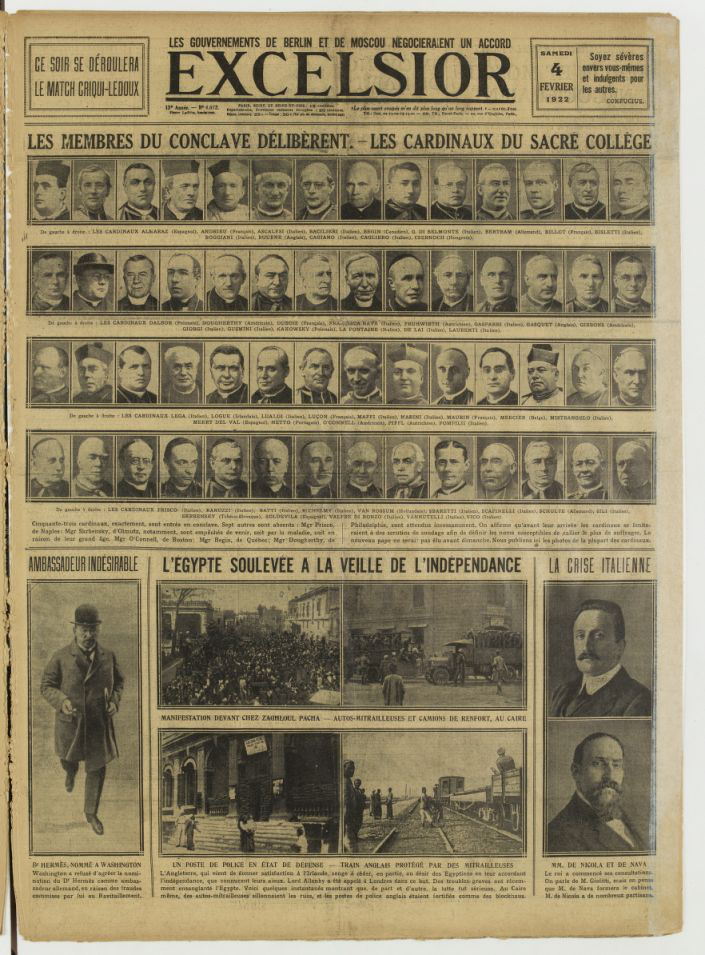

In [13]:
import io
from PIL import Image # pip install pillow
from PIL.Image import Image as PilImage
import matplotlib.pyplot as plt
import textwrap

def path_to_pil(file):   
    fileName = "".join([docID,"/",file]) # the images have been stored in a folder based on the document ID like 12148/btv1b103365619
    #print "--- loading image ",fileName,"..."
    img = Image.open(fileName)
    return img

def display_images(
    images, 
    columns=6, width=18, height=8, max_images=20, 
    label_wrap_length=20, label_font_size=8):

    if len(images) == 1:
        display(images[0])
        return 
    if not images:
        print ("No images to display!")
        return

    if len(images) > max_images:
        print ("Showing", max_images, "images of", len(images))
        images=images[0:max_images]

    height = max(height, int(len(images)/columns) * height)
    plt.figure(figsize=(width, height))
    for i, image in enumerate(images):

        plt.subplot(int(len(images) / columns) + 1, columns, i + 1)
        plt.imshow(image)

        if hasattr(image, 'filename'):
            title=image.filename
            if title.endswith("/"): title = title[0:-1]
            title=os.path.basename(title)
            title=textwrap.wrap(title, label_wrap_length)
            title="\n".join(title)
            plt.title(title, fontsize=label_font_size); 
            
# first we read the images
import os, fnmatch
entries = fnmatch.filter(os.listdir(docID), '*.jpg')
images = [path_to_pil(e) for e in entries]
display_images(images)
#for im in images:
#   display(im)




### 3. Now we process the images for face detection

In [15]:
# using the dnn module : https://docs.opencv.org/master/d2/d58/tutorial_table_of_content_dnn.html
import numpy as np
import libGL
import cv2
from imutils import paths
import csv

#######################
output_dir = os.path.realpath(output)
if not os.path.isdir(output_dir):
    print(f"\n  Output .csv directory {output} does not exist!\n")
    os.mkdir(output_dir);
else:
    print (f"\n... CSV files will be saved to {output}\n")

# writing the results in out_path
out_path = os.path.join(output, "classifications.csv" )
out_file = open(out_path,"w")

# detecting  homothetic contours
homothetic_threshold = 1.3 # 30%  tolerance
area_threshold =1.4 # 40%  tolerance
n_faces = 0


# test if the bounding box is homothetic to the source image and has a similar size
def homothetic(c1,c2,area1,area2):  # (x,y,w,h)
    ratio1 = float(c1[2]) / float(c1[3])
    ratio2 = float(c2[2]) / float(c2[3])
    tmp=max(ratio1,ratio2)/min(ratio1,ratio2)
    print ("ratio area:%f" % (area1/area2))
    print ("ratio w: %f - ratio h : %f - max-min : %f" % (ratio1, ratio2, tmp))
    if tmp < homothetic_threshold and ((area1/area2) < area_threshold):
        return True
    else:
        return False
    
def process_image(im):
    
	global n_faces # total number of detected faces
	n_faces_im = 0 #  number of detected faces
    
	# load the input image and construct an input blob for the image
	# by resizing to a fixed 300x300 pixels and then normalizing it
	file_name=im.filename
	image = cv2.imread(file_name)
	(h, w) = image.shape[:2]
	areaImg = h * w
	blob = cv2.dnn.blobFromImage(cv2.resize(image, (300, 300)), 1.0,(300, 300), (104.0, 177.0, 123.0))
	outText=""
	print ("\n**************\n",file_name)
	docID = file_name[0:-4]
    
	# pass the blob through the network and obtain the detections and predictions
	net.setInput(blob)
	detections = net.forward()
	# loop over the detections
	for i in range(0, detections.shape[2]):
			# extract the confidence (i.e., probability) associated with the prediction
			confidence = detections[0, 0, i, 2]
			# filter out weak detections by ensuring the `confidence` is greater than the minimum confidence
			if (confidence > min_confidence):
				# compute the (x, y)-coordinates of the bounding box for the object
				box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
				(startX, startY, endX, endY) = box.astype("int")
				wBox = endX-startX
				hBox = endY-startY
				if ((endX > w) or (endY > h)):
					print (f" # out of image : {w} {h} #")
				elif homothetic((0,0,w,h),(startX, startY, wBox, hBox), areaImg, wBox*hBox):
					print (f" # homothetic : {w} {h} #")
				else:
					n_faces += 1
					text = "{:.2f}%".format(confidence * 100)
					#print "\t%s" % text
					#print (startX, startY,(endX-startX),(endY-startY))
					# draw the boxes. If evaluation, later
					if not(eval_flag):
						cv2.rectangle(image, (startX, startY), (endX, endY),(0, 0, 255), 1)
						cv2.putText(image, file_name, (startX, startY),cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 00), 1)
						cv2.putText(image, text, (startX, startY+30),cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 200),2)
					# build the csv data
					if (outText ==""):
						# for evaluation, we only consider the case of one face per image
						if eval_flag:
							if file_name in gt.keys():
								print (" -> we have a GT")
								gt_crop = gt[file_name]
								evals.append(Detection(file_name,gt_crop,[startX, startY, endX, endY]))
							else:
								print (f" -> {file_name} has no GT")
						outText = "%d,%d,%d,%d,%.2f" % (startX, startY,wBox,hBox, confidence)
					else:
						outText = "%s %d,%d,%d,%d,%.2f" % (outText, startX, startY,wBox,hBox,confidence)

    # convert from openCV2 to PIL. Notice the COLOR_BGR2RGB which means that 
	# the color is converted from BGR to RGB
	color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	pil_image=Image.fromarray(color_coverted)
        
	if outText != "":
		print ("->",outText)
		# write in the .csv file
		print ("%s\t%s" % (file_name,outText), file=out_file) 
	else:
		print (" --> no detection!")
		if eval_flag:
			if file_name in gt.keys():
				print (" ...but we have a GT!")
				gt_crop = gt[file_name]
				evals.append(Detection(file_name,gt_crop,[0,0,0,0]))
	# show the output image
	if not(eval_flag):
		display(pil_image)
        
##############################
# Evaluation
# IOU computation
def intersection_over_union(boxA, boxB):
	# determine the (x, y)-coordinates of the intersection rectangle
	xA = max(boxA[0], boxB[0])
	yA = max(boxA[1], boxB[1])
	xB = min(boxA[2], boxB[2])
	yB = min(boxA[3], boxB[3])
	# compute the area of intersection rectangle
	interArea = max(0, xB - xA + 1) * max(0, yB - yA + 1)
	# compute the area of both the prediction and ground-truth
	# rectangles
	boxAArea = (boxA[2] - boxA[0] + 1) * (boxA[3] - boxA[1] + 1)
	boxBArea = (boxB[2] - boxB[0] + 1) * (boxB[3] - boxB[1] + 1)
	# compute the intersection over union by taking the intersection
	# area and dividing it by the sum of prediction + ground-truth
	# areas - the interesection area
	iou = interArea / float(boxAArea + boxBArea - interArea)
	# return the intersection over union value
	return iou

# building the image with its GT and prediction crops
def process_eval(detection):
	print (detection)
	# load the image
	image = cv2.imread(detection.image_path)
	# draw the ground-truth bounding box along with the predicted
	# bounding box
	cv2.rectangle(image, tuple(detection.gt[:2]),
		tuple(detection.gt[2:]), (0, 255, 0), 1)
	cv2.rectangle(image, tuple(detection.pred[:2]),
		tuple(detection.pred[2:]), (0, 0, 200), 1)
	# compute the intersection over union and display it
	iou = intersection_over_union(detection.gt, detection.pred)
	cv2.putText(image, detection.image_path, (10, 30),
		cv2.FONT_HERSHEY_SIMPLEX, 0.4, (0, 0, 0), 1)
	cv2.putText(image, "IoU: {:.4f}".format(iou), (10, 50),
		cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 200, 0), 2)
	print(" -> {}: {:.3f}".format(detection.image_path, iou))
	iou_mean.append(iou)
	# show the output image
	color_coverted = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	pil_image=Image.fromarray(color_coverted)
	#cv2.imshow("Image", image)
	#cv2.waitKey(0)
	display(pil_image)
    
    
def Average(lst):
    return sum(lst) / len(lst)

## Main ##       
print(" loading model...")
# Single Shot Detector (SSD) model / https://arxiv.org/abs/1512.02325
# https://towardsdatascience.com/review-ssd-single-shot-detector-object-detection-851a94607d11
net = cv2.dnn.readNetFromCaffe("deploy.prototxt.txt", "res10_300x300_ssd_iter_140000.caffemodel")

# reading the ground truth
if eval_flag:
	print("... reading the ground truth")
	with open(gt_file, newline='') as csvfile:
		spamreader = csv.reader(csvfile, delimiter='\t', quotechar='|')
		for row in spamreader:
			#print(', '.join(row))
			print ("  file: ",row[0]) # the file
			crop = row[1].split(',') # the crop
			int_array = [int(numeric_string) for numeric_string in crop]
			gt[row[0]] = int_array
	print (f"... we get {len(gt)} images with a ground truth")

print ("... now infering")
foo=[process_image(im) for im in images]
out_file.close()
print (f"\n ... writing classification data in {output} \n")

print (f"\n ### faces detected: {n_faces} ###")
print (f" ### images analysed: {len(images)} ###")

if eval_flag:
	print("\n... now evaluating")
	# processing the predictions which have a GT
	if len(evals)==0:
		print (" -> we don't have any GT!")
	else:
		[process_eval(e) for e in evals]
		print ("---------------------------")
		print (" -> average of IOUs: {:.3f}".format(Average(iou_mean)))

ModuleNotFoundError: No module named 'libGL'